In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

<div class="alert alert-warning">
<font size="5"><strong> A nonlinear Poisson equation</strong></font>
</div>

We shall now address how to solve nonlinear PDEs. We will see that
nonlinear problems can be solved just as easily as linear problems in
FEniCS, by simply defining a nonlinear variational problem and calling
the `solve` function. When doing so, we will encounter a subtle
difference in how the variational problem is defined.

<div class="alert alert-warning">
<font size="5"><strong> PDE problem </strong></font>
</div>

As a model problem for the solution of nonlinear PDEs, we
take the following nonlinear Poisson equation:

\begin{equation}
-\nabla\cdot\left(q(u)\nabla u\right) = f,
\end{equation}

in $\Omega$, with $u=u_D$ on the boundary $\partial\Omega$.
The coefficient $q = q(u)$ makes the equation nonlinear (unless $q(u)$
is constant in $u$).

<div class="alert alert-warning">
<font size="5"><strong> Variational formulation </strong></font>
</div>

As usual, we multiply our PDE by a test function $v\in\hat V$,
integrate over the domain, and integrate the second-order derivatives
by parts. The boundary integral arising from integration by parts
vanishes wherever we employ Dirichlet conditions. The resulting
variational formulation of our model problem becomes: find $u \in V$
such that

\begin{equation}
F(u; v) = 0 \ \ \ \ \forall v \in \hat{V},
\end{equation}

where

\begin{equation}
F(u; v) = \int_\Omega (q(u)\nabla u\cdot \nabla v - fv) dx,
\end{equation}

and

\begin{align*}
     V      &= \{v \in H^1(\Omega) : v = u_D \mbox{ on } \partial\Omega\},\\
    \hat{V} &= \{v \in H^1(\Omega) : v = 0 \mbox{ on } \partial\Omega\}.
\end{align*}

The discrete problem arises as usual by restricting $V$ and $\hat V$
to a pair of discrete spaces. As before, we omit any subscript on
the discrete spaces and discrete solution.
The discrete nonlinear problem is then written as: find $u_h \in V$ such that

\begin{equation}
  F(u_h; v) = 0 \ \ \ \ \  \forall v \in \hat{V}.
\end{equation}

Linearizing the semilinear form $F$ around $u=u_h$, we obtain

$$
F'(u_h;\delta u,v) = \int_\Omega \bigg[(2 \delta u\nabla u_h)\cdot\nabla v + ((1+u_h^2)\nabla\delta u)\nabla v \bigg] \,{\rm dx}
$$

We note that for each fixed $u_h$,

* $a = F′(u_h;⋅,⋅)$ is a bilinear form

* and $L=F(u_h;⋅)$ is a linear form.

In each Newton iteration, we thus solve a linear variational problem of the canonical form: find $ δu ∈ V_{h,0}$ such that

$$
F'(u_h;\delta u,v) = - F(u_h;v)\quad\forall\,v\in\hat{V}_h.
$$

In the following we solve the problem with the following data:

-  (a unit square)
$$
\Omega = [0,1] \times [0,1]\,\,\,  $$

- The source term $f$ and $u_D$ are calculated from the exact solution:
$$u(x, y) = 1 + x + 2y.\,\,\,$$

<div class="alert alert-warning">
<font size="5"><strong> FEniCS implementation: Using Newton's method in FEniCS </strong></font>
</div>


### Test problem ###

To solve a test problem, we need to choose the right-hand side $f$,
the coefficient $q(u)$ and the boundary value $u_D$.  Previously, we
have worked with manufactured solutions that can be reproduced without
approximation errors. This is more difficult in nonlinear problems,
and the algebra is more tedious. However, we may utilize SymPy for
symbolic computing and integrate such computations in the FEniCS
solver. This allows us to easily experiment with different
manufactured solutions. The forthcoming code with SymPy requires some
basic familiarity with this package. In particular, we will use the
SymPy functions `diff` for symbolic differentiation and `ccode` for
C/C++ code generation.

We take $q(u) = 1 + u^2$ and define a two-dimensional manufactured
solution that is linear in $x$ and $y$:

In [ ]:
from dolfin import *

def q(u):
    "Return nonlinear coefficient"
    return 1 + u**2

# Symbolic computation
This is accomplished with `sympy` by defining the names of `x` and `y` as `x[0]` and `x[1]`:

```x, y = sym.symbols('x[0], x[1]')```

In [ ]:
# Use SymPy to compute f from the manufactured solution u
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y

f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)

Turning the expressions for `u` and `f` into C or C++ syntax for
FEniCS `Expression` objects needs two steps. First, we ask for the C
code of the expressions:

In [ ]:
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)

print('u =', u_code)
print('f =', f_code)

u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


After having defined the mesh, the function space, and the boundary, we define the boundary value `u_D` and the right-hand side function as

```
u_D = Expression(u_code, degree=1)
#
f = Expression(f_code, degree=1)
```

## FEniCS implementation

A solver for the nonlinear Poisson equation is as easy to implement as a solver for the linear Poisson equation.

All we need to do is to state the formula for $F$ and call

```
solve(F == 0, u, bc)
```
instead of `solve(a == L, u, bc)` as we did
in the linear case.

The `solve` function takes the nonlinear equations, derives symbolically the Jacobian matrix, and runs a Newton method to compute the solution.

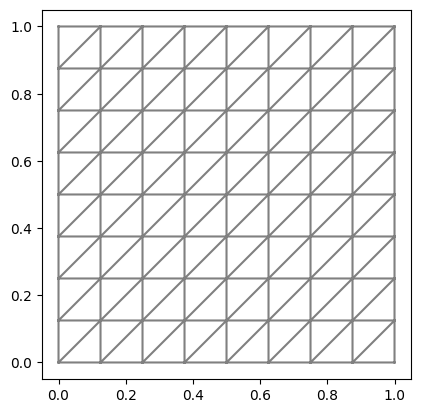

In [ ]:
%matplotlib inline

n = 8

mesh = UnitSquareMesh(n, n)
plot(mesh)

# Create mesh and define function space

V = FunctionSpace(mesh, 'P', 1)

The definition of the Dirichlet boundary condition and the load function:

In [ ]:
def boundary(x, on_boundary):
    return on_boundary

u_D = Expression(u_code, degree=1)
bc = DirichletBC(V, u_D, boundary)

f = Expression(f_code, degree=1)

By defining the function in this step and omitting the trial function we tell FEniCS that the problem is nonlinear. With these ingredients, we can write down the semilinear form F (using UFL operators). In summary, this reads:

In [ ]:
u = Function(V)    # Note: not TrialFunction!
v = TestFunction(V)
# Define variational problem
F = q(u)*dot(grad(u), grad(v))*dx - f*v*dx

Now, we have specified the variational forms and can consider the solution of the variational problem.

All we need to do is to state the formula for $F$ and call

```
solve(F == 0, u, bc)
```
instead of `solve(a == L, u, bc)` as we did
in the linear case.

The `solve` function takes the nonlinear equations, derives symbolically the Jacobian matrix, and runs a Newton method to compute the solution.

**The major difference from a linear problem is that the unknown function `u` in the variational form in the nonlinear case must be defined as a `Function`, not as a `TrialFunction`. In some sense
this is a simplification from the linear case where we must define `u` first as a `TrialFunction` and then as a `Function`.**


In [ ]:
# Compute solution
solve(F == 0, u, bc)

The Newton procedure is considered to have converged when the residual $r_n$ at iteration $n$ is less than the absolute tolerance or the relative residual $\frac{r_n}{r_0}$ is less than the relative tolerance.

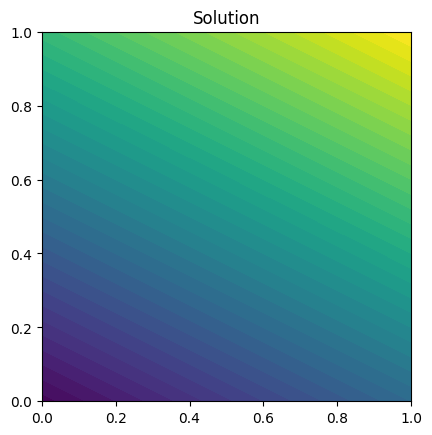

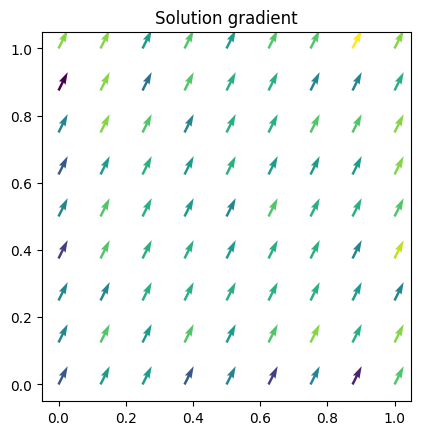

In [ ]:
# Plot solution and solution gradient
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Solution")
plt.figure()
plot(grad(u), title="Solution gradient")

# Save solution in VTK format
#file = File("nonlinear_poisson.pvd")
#file << u

The current example shows how easy it is to solve a nonlinear problem
in FEniCS. However, experts on the numerical solution of nonlinear
PDEs know very well that automated procedures may fail for nonlinear
problems, and that it is often necessary to have much better manual
control of the solution process than what we have in the current
case.

**We can also control the Newton's solver.**

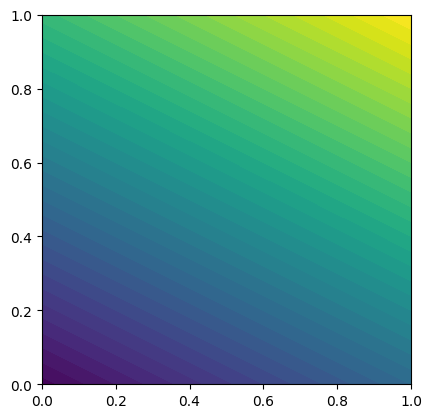

In [ ]:
# Compute solution
solve(F == 0, u, bc,
      solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
plot(u)

## Exercice 1.

### We use FEniCS's automated Newton's method to solve the nonlinear system.

Solve the following problem for a PDE with known exact solution.

$$ - \nabla \cdot( q \nabla u) = f  \text{ on } \Omega = [0, 1]\times[0, 1] , $$
$$u(x, y) = x \text{ in } \Gamma_D = \Gamma_{left} \cup \Gamma_{right}  ,  $$
$$\frac{du}{dy} (x, y) = 0 \text{ in } \Gamma_N = \Gamma_{top} \cup \Gamma_{bottom}  ,$$


where $$q = q(u) = (1 + u)^5$$

The exact solution is $$u(x, y) = (63 x + 1)^{1/6} - 1.$$

We use FEniCS's automated Newton's method to solve the nonlinear system.

L2 error:   4.66e-03   H1 error:   2.40e-01


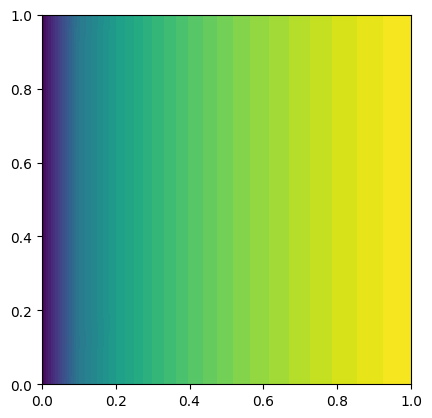

In [ ]:
from dolfin import *
#
# the coefficient function
#
def q(u):
    return (1 + u)**5
#
# Create mesh and define function space
#
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, 'Lagrange', 2)
#
# Dirichlet boundary (left and right edges of the square)
#
def Gamma_d(x, on_boundary):
    return (near(x[0], 0.) or near(x[0], 1.)) and on_boundary
#
# data
#
g = Expression('x[0]', degree=1)
f = Expression('x[0]', degree=1)

bc = DirichletBC(V, g, Gamma_d)
#
# initial iterate:  u0(x, y) = x
#
u0 = Expression('x[0]', degree=1)
uold = interpolate(u0, V)
#
# Define nonlinear weak formulation
#
tol = 1.e-6
u = uold  # most recently computed solution
v = TestFunction(V)
F = q(u) * inner(grad(u), grad(v)) * dx  - f*v*dx
#
# solve nonlinear problem using Newton's method.
#
solve(F == 0, u, bc, solver_parameters={"newton_solver": {"absolute_tolerance": tol}})
#
# use the exact solution to compute the error
#
uexp = Expression('pow(63.*x[0] + 1, 1./6.) - 1.', degree=6)
Vf = FunctionSpace(mesh, 'Lagrange', 4)
uex = interpolate(uexp, Vf)
uh=interpolate(u, Vf)
#
# L2 norm
#
L2norm = errornorm ( uex, uh, 'L2' )
#
# H1seminorm
#
H1seminorm = errornorm ( uex, uh, 'H10' )
print('L2 error: {:10.2e}   H1 error: {:10.2e}'.format(L2norm, H1seminorm))

plot(u)

## Exercice 2.

### Implemention of  Picard iteration under Fenics to solve the nonlinear system.

Solve the following problem for a PDE with known exact solution.

$$ - \nabla \cdot( q \nabla u) = 0  \text{ on } \Omega = [0, 1]\times[0, 1] , $$
$$u(x, y) = x \text{ in } *\Gamma_D = *\Gamma_{left} \cup \Gamma_{right}  ,  $$
$$\frac{du}{dy} (x, y) = 0 \text{ in } \Gamma_N = \Gamma_{top} \cup \Gamma_{bottom}  ,$$


where $$q = q(u) = (1 + u)^5$$

The exact solution is $$u(x, y) = (63 x + 1)^{1/6} - 1.$$

We use the hand-calculations and manual implementation of Picard method to solve the nonlinear system.

**Note:** Picard Iteration

Picard iteration is an easy way of handling nonlinear PDEs: we simply use a known, previous solution in the nonlinear terms so that these terms become linear in the unknown $u$. The strategy is also known as the method of successive substitutions. For our particular problem, we use a known, previous solution in the coefficient $q(u)$.

More precisely, given a solution $u^k$ from iteration $k$, we seek a new  solution $u^{k+1}$ in iteration $k+1$ such that $u^{k+1}$ solves the linear problem,

$$ - \nabla \cdot( q(u^{k}) \nabla u^{k+1}) = 0  \text{ on } \Omega = [0, 1]\times[0, 1] , $$



The iterations require an initial guess $u^0$. The hope is that $u^{k} \rightarrow u$ as $k \rightarrow \infty$, and that $u^{k+1}$ is sufficiently close to the exact solution $u$ of the discrete problem after just a few iterations.

We can easily formulate a variational problem for $u^{k+1}$ from the last equation. Equivalently, we can approximate $q(u)$ by $q(u^k)$ in $\int_\Omega q(u)\nabla u\cdot \nabla v \, \mathrm{d}x$ to obtain the same linear variational problem. In both cases, the problem consists of seeking $u^{k+1} \in V $ such that

iteration  1  L2 norm of delta:   2.88e-01
iteration  2  L2 norm of delta:   5.63e-02
iteration  3  L2 norm of delta:   5.93e-02
iteration  4  L2 norm of delta:   1.45e-02
iteration  5  L2 norm of delta:   1.34e-02
iteration  6  L2 norm of delta:   4.48e-03
iteration  7  L2 norm of delta:   3.03e-03
iteration  8  L2 norm of delta:   1.40e-03
iteration  9  L2 norm of delta:   6.34e-04
iteration 10  L2 norm of delta:   4.09e-04
iteration 11  L2 norm of delta:   1.27e-04
iteration 12  L2 norm of delta:   1.11e-04
iteration 13  L2 norm of delta:   2.72e-05
iteration 14  L2 norm of delta:   2.84e-05
iteration 15  L2 norm of delta:   7.37e-06
iteration 16  L2 norm of delta:   6.80e-06
iteration 17  L2 norm of delta:   2.32e-06
iteration 18  L2 norm of delta:   1.52e-06
iteration 19  L2 norm of delta:   7.18e-07
convergence after 19 Picard iterations
L2 error:   4.66e-03   H1 error:   2.40e-01


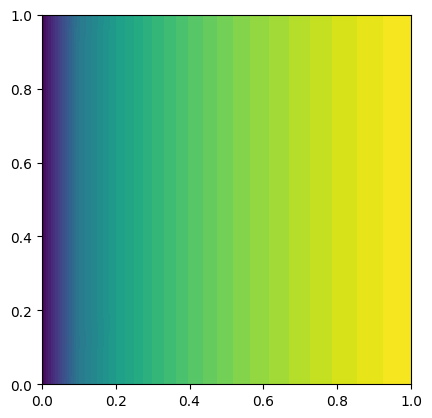

In [ ]:
from dolfin import *
#
# the coefficient function
#
def q(u):
    return (1 + u)**5
#
# Create mesh and define function space
#
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, 'Lagrange', 2)
#
# Dirichlet boundary (left and right edges of the square)
#
def Gamma_d(x, on_boundary):
    return (near(x[0], 0.) or near(x[0], 1.)) and on_boundary

#
# data
#
g = Expression('x[0]', degree=1)
f = Expression('x[0]', degree=1)

bc = DirichletBC(V, g, Gamma_d)
# initial iterate:  u(x, y) = x
u0 = Expression('x[0]', degree=1)
uold = interpolate(u0, V)

# Define variational problem for Picard iteration
u = TrialFunction(V)
v = TestFunction(V)
a = q(uold) * inner(grad(u), grad(v)) * dx
L = f*v*dx
u = Function(V)

# Picard iteration
tol = 1.0E-6
maxiter = 50
#
# compute next Picard iterate
#
for iter in range(maxiter):
    solve(a == L, u, bc)
    #
    # check increment size as convergence test
    #
    eps = errornorm ( u, uold, 'L2' )
    print('iteration{:3d}  L2 norm of delta: {:10.2e}'.format(iter+1, eps))
    if eps < tol:
        break
    uold.assign(u)

if eps > tol:
    print('no convergence after {} Picard iterations'.format(iter+1))
else:
    print('convergence after {} Picard iterations'.format(iter+1))
#
# use the exact solution to compute the error
#
uexp = Expression('pow(63.*x[0] + 1, 1./6.) - 1.', degree=6)
Vf = FunctionSpace(mesh, 'Lagrange', 4)
uex = interpolate(uexp, Vf)
uh=interpolate(u, Vf)
#
# L2 norm
#
L2norm = errornorm ( uex, uh, 'L2' )
#
# H1seminorm
#
H1seminorm = errornorm ( uex, uh, 'H10' )
print('L2 error: {:10.2e}   H1 error: {:10.2e}'.format(L2norm, H1seminorm))

plot(u)

L2 error:   7.53e+00   H1 error:   5.11e+00


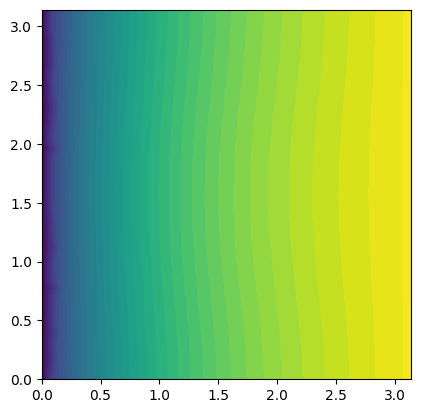

In [ ]:
from dolfin import *
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
#
# the coefficient function
#
def q(u):
    return u
#
# Create mesh and define function space
#
domain = Rectangle(Point(0.0, 0.0), Point(np.pi, np.pi))

# Generate mesh
mesh = generate_mesh(domain, 20)
V = FunctionSpace(mesh, 'Lagrange', 2)
#
# Dirichlet boundary (left and right edges of the square)
#
def Gamma_d(x, on_boundary):
    return (near(x[0], 0.) or near(x[0], np.pi)) and on_boundary
#
# data
#
g = Expression('x[0]', degree=1)
f = Expression('sin(x[0])*sin(x[1])', degree=1)

bc = DirichletBC(V, g, Gamma_d)
#
# initial iterate:  u0(x, y) = x
#
u0 = Expression('x[0]', degree=1)
uold = interpolate(u0, V)
#
# Define nonlinear weak formulation
#
tol = 1.e-6
u = uold  # most recently computed solution
v = TestFunction(V)
F = q(u) * inner(grad(u), grad(v)) * dx  - f*v*dx
#
# solve nonlinear problem using Newton's method.
#
solve(F == 0, u, bc, solver_parameters={"newton_solver": {"absolute_tolerance": tol}})
#
# use the exact solution to compute the error
#
uexp = Expression('0.0', degree=6)
Vf = FunctionSpace(mesh, 'Lagrange', 4)
uex = interpolate(uexp, Vf)
uh=interpolate(u, Vf)
#
# L2 norm
#
L2norm = errornorm ( uex, uh, 'L2' )
#
# H1seminorm
#
H1seminorm = errornorm ( uex, uh, 'H10' )
print('L2 error: {:10.2e}   H1 error: {:10.2e}'.format(L2norm, H1seminorm))

plot(u)